In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from random import randint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
num_classes = 10

# preprocessing
train_images = train_images / 255.0
test_images = test_images / 255.0

# change labels to categorical
train_labels_bin = keras.utils.to_categorical(train_labels, num_classes)
test_labels_bin = keras.utils.to_categorical(test_labels, num_classes)

number_ind = []
for i in range(10):
  number_ind.append(train_labels == i)

In [ ]:
def mnistModel():
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28, 1)),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation='softmax')
  ])
    
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])
  return model

#### CIFAR

In [ ]:
# ## CIFAR DATASET AND MODEL

# cifar10 = keras.datasets.cifar10
# (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# num_classes = 10

# # preprocessing
# train_images = train_images / 255.0
# test_images = test_images / 255.0

# # normalize images
# train_images_norm = (train_images - np.mean(train_images, axis=(0, 1, 2, 3))) / np.std(train_images, axis=(0, 1, 2, 3))
# test_images_norm = (test_images - np.mean(test_images, axis=(0, 1, 2, 3))) / np.std(test_images, axis=(0, 1, 2, 3))

# # change labels to categorical
# train_labels_bin = keras.utils.to_categorical(train_labels, num_classes)
# test_labels_bin = keras.utils.to_categorical(test_labels, num_classes)

# def cifar10model():
#   # define the model; architecture inspired by Keras documentation
#   model = keras.Sequential([
#       keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=train_images.shape[1:], activation='relu'),
#       keras.layers.Conv2D(32, (3, 3), activation='relu'),
#       keras.layers.MaxPooling2D(pool_size=(2, 2)),
#       keras.layers.Dropout(0.25),
#       keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
#       keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
#       keras.layers.MaxPooling2D(pool_size=(2, 2)),
#       keras.layers.Dropout(0.25),
#       keras.layers.Flatten(),
#       keras.layers.Dense(512, activation='relu'),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(num_classes, activation='softmax')
#   ])
#   model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#              metrics=['accuracy'])
#   return model

### Standard Training

In [ ]:
model = mnistModel()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_results = model.fit(train_images, train_labels_bin, batch_size=32, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2618 - accuracy: 0.9248
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1180 - accuracy: 0.9650
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0807 - accuracy: 0.9752
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0600 - accuracy: 0.9820
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0466 - accuracy: 0.9856
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0362 - accuracy: 0.9889
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0292 - accuracy: 0.9912
Epoch 8/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0236 - accuracy: 0.9924
Epoch 9/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0190 - accuracy: 0.9942
Epoch 10/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.016

In [ ]:
results = model.evaluate(test_images, test_labels_bin, batch_size=128)

79/79 [==============================] - 0s 2ms/step - loss: 0.1159 - accuracy: 0.9758


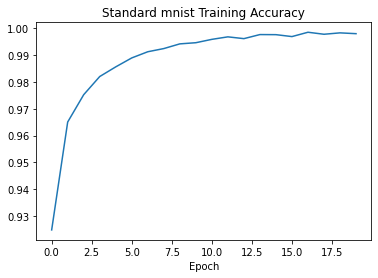

In [ ]:
sns.lineplot(list(range(len(train_results.history['accuracy']))), train_results.history['accuracy'])
plt.title('Standard mnist Training Accuracy')
plt.xlabel('Epoch')
plt.show()

### Setup for Federated Learning

In [ ]:
class FederatedClient:
  trainImages = None
  trainLabels = None
  model = None

  def __init__(self, model, trainImages, trainLabels):
    self.model = model
    self.trainImages = trainImages
    self.trainLabels = trainLabels

  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      self.model.weights[layer_index].assign(serverModel.weights[layer_index])
  
  def fit(self):
    self.model.fit(self.trainImages, self.trainLabels, batch_size=32, epochs=1)

  def getModel(self):
    return self.model

  def evaluate(self, testImages, testLabels, globalAccuracy, batch_size=32):
    # evaluate accuracy and utility
    acc = self.evaluate_accuracy(testImages, testLabels, batch_size)
    utility = self.evaluate_utility(acc[1], globalAccuracy)
    return acc, utility

  def evaluate_accuracy(self, testImages, testLabels, batch_size=32):
    return self.model.evaluate(testImages, testLabels, batch_size)

  def evaluate_utility(self, localAccuracy, globalAccuracy):
    # utility = local acc - global acc
    return localAccuracy - globalAccuracy

In [ ]:
# Server class holds a server model and testing data
class FederatedServer:

  model = None
  testImages = None
  testLabels = None

  def __init__(self, model, testImages, testLabels):
    self.model = model
    self.testImages = testImages
    self.testLabels = testLabels

  # Averaging client models using the averaging method
  def average(self, federatedClients, averagingMethod):
    allWeights = []

    for i in range(len(federatedClients)):
      allWeights.append(federatedClients[i].getModel().weights)
    
    avgWeights = averagingMethod(allWeights) 
    
    for layer_index in range(len(avgWeights)):
      self.model.weights[layer_index].assign(avgWeights[layer_index])
  
  # evaluate the test accuracies and utility for all clients
  def evaluate_clients(self, federatedClients, globalAccuracy):
    results = []
    for client in federatedClients:
      results.append(client.evaluate(self.testImages, self.testLabels, globalAccuracy, batch_size=32))
    return results

  # Testing the server model
  def evaluate(self):
    return self.model.evaluate(self.testImages, self.testLabels, batch_size=32)

In [ ]:
# Adversarial Client 1: returns a constant (all ones) for every weight in the model
class AdversarialClient(FederatedClient):
  fakeModel = None
  
  def __init__(self, model, trainImages, trainLabels, fakeModel):
    super(AdversarialClient, self).__init__(model, trainImages, trainLabels)
    self.fakeModel = fakeModel

  
  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      self.fakeModel.weights[layer_index].assign(np.ones(layer_shape))

  def fit(self):
    pass
  
  def getModel(self):
    return self.fakeModel

In [ ]:
# Adversarial Client 2: returns a Uniform(0, 1) value for each weight in model
class AdversarialClient2(AdversarialClient):


  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      self.fakeModel.weights[layer_index].assign(np.random.uniform(size = layer_shape))

  def fit(self):
    pass

In [ ]:
# Adversarial Client 3: returns noisy trained model, then substracts noise from aggregate model to get more useful model
class AdversarialClient3(AdversarialClient):
  def __init__(self, model, trainImages, trainLabels, fakeModel, num_clients=10):
    super(AdversarialClient3, self).__init__(model, trainImages, trainLabels, fakeModel)
    self.noise = None
    self.num_clients = num_clients # assume number of participating clients is known by adversary

  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      self.fakeModel.weights[layer_index].assign(serverModel.weights[layer_index])
    
    # compute the "true" model by removing noise
    if self.noise != None:
      for layer_index in range(len(self.model.weights)):
        self.model.weights[layer_index].assign(self.fakeModel.weights[layer_index] - self.noise[layer_index] / self.num_clients)

  def fit(self):
    # fit the model properly
    FederatedClient.fit(self)
    
    # add and save Gaussian noise
    self.noise = []
    for layer_index in range(len(self.model.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      layer_noise = np.random.uniform(-1, 1, size=layer_shape)
      self.noise.append(layer_noise)
      self.fakeModel.weights[layer_index].assign(self.model.weights[layer_index] + layer_noise)



In [ ]:
# Adversarial Client 4: Returns a random model, saves first iteration's model and improved upon it  
class AdversarialClient4(AdversarialClient):
  def __init__(self, model, trainImages, trainLabels, fakeModel, num_clients=10):
    super(AdversarialClient4, self).__init__(model, trainImages, trainLabels, fakeModel)
    self.noise = None
    self.num_clients = num_clients # assume number of participating clients is known by adversary
    self.counter  = 0 

  def assignServerModel(self, serverModel):
#    for layer_index in range(len(serverModel.weights)):
#      layer_shape = self.fakeModel.weights[layer_index].shape
#      self.fakeModel.weights[layer_index].assign(serverModel.weights[layer_index])
    
    if (self.counter == 1):
      for layer_index in range(len(self.model.weights)):
        self.model.weights[layer_index].assign(serverModel.weights[layer_index]- self.noise[layer_index]/self.num_clients + self.model.weights[layer_index]/self.num_clients)

    self.counter += 1

  def fit(self):
    # fit the model properly
    FederatedClient.fit(self)
    
    # add and save Gaussian noise
    self.noise = []
    for layer_index in range(len(self.model.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      layer_noise = np.random.uniform(0, 1, size=layer_shape)
      self.noise.append(layer_noise)
      self.fakeModel.weights[layer_index].assign(layer_noise)


In [ ]:
# Adversarial Client non IID: Does not help or hurt, and improves upon final model locally  
class AdversarialClientNonIID(AdversarialClient):
  def __init__(self, model, trainImages, trainLabels, fakeModel):
    super(AdversarialClientNonIID, self).__init__(model, trainImages, trainLabels, fakeModel)

  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      self.fakeModel.weights[layer_index].assign(serverModel.weights[layer_index])

    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.model.weights[layer_index].shape
      self.model.weights[layer_index].assign(serverModel.weights[layer_index])

  def fit(self):
    # fit the model properly
    FederatedClient.fit(self)

In [ ]:
# Adversarial Client 5: returns noisy trained model, then substracts noise from aggregate model to get more useful model in slightly different way than Adversarial Client 3 
class AdversarialClient5(AdversarialClient):
  def __init__(self, model, trainImages, trainLabels, fakeModel, num_clients=10):
    super(AdversarialClient5, self).__init__(model, trainImages, trainLabels, fakeModel)
    self.noise = None
    #self.trueModel = mnistModel()
    self.num_clients = num_clients # assume number of participating clients is known by adversary
    self.round_num = 0 
    self.noNoiseModel = mnistModel()
    
  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      self.fakeModel.weights[layer_index].assign(serverModel.weights[layer_index])
    

    # compute the "no noise" model by removing noise
    if self.noise != None:
      for layer_index in range(len(self.fakeModel.weights)):
        self.noNoiseModel.weights[layer_index].assign(self.fakeModel.weights[layer_index] - self.noise[layer_index] / self.num_clients)


  def fit(self):
    self.fakeModel.fit(self.trainImages, self.trainLabels, batch_size=128, epochs=1)
    
    # add and save noise
    self.noise = []
    for layer_index in range(len(self.fakeModel.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      layer_noise = np.random.uniform(-1, 1, size=layer_shape)
      self.noise.append(layer_noise)
      self.fakeModel.weights[layer_index].assign(self.fakeModel.weights[layer_index] + layer_noise)

    # update true model 
    self.noNoiseModel.fit(self.trainImages, self.trainLabels, batch_size=128, epochs=1)
    
    for layer_index in range(len(self.model.weights)):
      #(prev_avg * n + x) / (n + 1)
      self.model.weights[layer_index].assign((self.model.weights[layer_index] * self.round_num + self.noNoiseModel.weights[layer_index]) / (self.round_num +1)) 
    self.round_num = self.round_num + 1
    


  #def evaluate_accuracy(self, testImages, testLabels, batch_size=32):
  #  return self.trueModel.evaluate(testImages, testLabels, batch_size)

### Sampling Scheme

In [ ]:
import random

In [ ]:
def sample_iid(train_labels, data_percentage):
  total_data = train_labels.shape[0]
  indices_all = np.array([randint(0, NUM_CLIENTS-1) for _ in range(total_data)])
  # add a mask
  mask = random.sample(list(range(total_data)), int(total_data * (1 - data_percentage)))
  indices_all[mask] = -1
  # indices = np.array([i if np.random.rand() < data_percentage else -1 for i in indices_all])
  return indices_all

In [ ]:
def sample_non_iid(train_labels, data_percentage, random_mix=0.5):
  total_data = train_labels.shape[0]
  ### Set client to have a single class of data (NEED TO CHANGE IF # OF CLIENTS CHANGES)
  indices_all = np.array(train_labels)

  n_random = int(total_data * random_mix)
  random_indices = random.sample(list(range(total_data)), n_random)
  indices_all[random_indices] = np.array([randint(0, NUM_CLIENTS-1) for _ in range(n_random)])
  # labels = set(total_data)
  # for label in labels:
  #   label_size = np.sum(indices_all == label)
  #   indices_all[indices_all == label] = np.array([randint(0, NUM_CLIENTS-1) for _ in range(int(random_mix * label_size))])

  # add a mask
  mask = random.sample(list(range(total_data)), int(total_data * (1 - data_percentage)))
  indices_all[mask] = -1
  return indices_all

### Standard Federated Learning
Using `FedAvg` under IID non-adversarial setting.

In [ ]:
def FederatedLearn(numRounds, federatedServer, federatedClients, averagingMethod):
  test_accs = []
  client_results = []
  
  # federated learning
  for r in range(numRounds):

    for i in range(len(federatedClients)):
#      print('Round #' + str(r + 1) + ' Device #' + str(i + 1))

      federatedClients[i].assignServerModel(federatedServer.model)

    #print('before')
    #federatedServer.evaluate_clients(federatedClients,0)

    for i in range(len(federatedClients)):
      print('Round #' + str(r + 1) + ' Device #' + str(i + 1))

      # train local device
      federatedClients[i].fit()
      
    # update server model with weights averaging
    federatedServer.average(federatedClients, averagingMethod)
    
    # test evaluation on server model
    print('Round #' + str(r + 1) + ' Testing')
    test_acc = federatedServer.evaluate()
    print('Round #' + str(r + 1) +' Test Accuracy:', test_acc[1])
    test_accs.append(test_acc)

    #print('after')
    # evaluate test accuracy and utility for each client
    client_results.append(federatedServer.evaluate_clients(federatedClients, test_acc[1]))
  
  return test_accs, client_results

In [ ]:
def myMean(weights):
  return np.mean(weights, axis=0)

def myMedian(list_of_weights):
  # use median over all network weights
  robust_weights = []
  for layer in range(len(list_of_weights[0])):
    layer_shape = list_of_weights[0][layer].shape
    layer_list = [list_of_weights[i][layer].numpy().flatten() for i in range(len(list_of_weights))]
    robust_weights.append(np.median(layer_list, axis=0).reshape(layer_shape))
  return robust_weights

In [ ]:
NUM_ROUNDS = 30
NUM_CLIENTS = 10
DATA_PERCENTAGE = 0.1

indices = sample_iid(train_labels, DATA_PERCENTAGE)

# Standard Federated Learning
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccs, clientResults = FederatedLearn(NUM_ROUNDS, server, clients, myMean)

# Adversarial with mean
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient4(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]], mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdvMean, clientResultsAdvMean = FederatedLearn(NUM_ROUNDS, server, clients, myMean)

# Adversarial with mean
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient5(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]], mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdv5Mean, clientResultsAdv5Mean = FederatedLearn(NUM_ROUNDS, server, clients, myMean)

referenceClient = FederatedClient(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]])

referenceAccs = []
print('reference')
for i in range(NUM_ROUNDS):
  referenceClient.fit()
  referenceAccs.append(referenceClient.evaluate(test_images, test_labels_bin, 0, batch_size=32))

referenceAccs = [[v] for v in referenceAccs]


# Adversarial with median
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient4(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]],  mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdv4Median, clientResultsAdv4Median = FederatedLearn(NUM_ROUNDS, server, clients, myMedian)

# Adversary 5 with median
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient5(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]],  mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdv5Median, clientResultsAdv5Median = FederatedLearn(NUM_ROUNDS, server, clients, myMedian)

Streaming output truncated to the last 5000 lines.
Round #3 Device #4
20/20 [==============================] - 0s 2ms/step - loss: 0.6693 - accuracy: 0.8298
Round #3 Device #5
19/19 [==============================] - 0s 2ms/step - loss: 0.6068 - accuracy: 0.8648
Round #3 Device #6
19/19 [==============================] - 0s 2ms/step - loss: 0.6378 - accuracy: 0.8447
Round #3 Device #7
21/21 [==============================] - 0s 2ms/step - loss: 0.7124 - accuracy: 0.8331
Round #3 Device #8
19/19 [==============================] - 0s 2ms/step - loss: 0.6958 - accuracy: 0.8317
Round #3 Device #9
19/19 [==============================] - 0s 2ms/step - loss: 0.6579 - accuracy: 0.8381
Round #3 Device #10
20/20 [==============================] - 0s 2ms/step - loss: 0.6799 - accuracy: 0.8349
Round #3 Testing
313/313 [==============================] - 0s 1ms/step - loss: 0.5525 - accuracy: 0.8697
Round #3 Test Accuracy: 0.869700014591217
313/313 [==============================] - 0s 1ms/step - l

In [ ]:
 NUM_ROUNDS = 30
NUM_CLIENTS = 10
DATA_PERCENTAGE = 0.1

indices = sample_non_iid(train_labels, DATA_PERCENTAGE, 0.1)

# Standard Federated Learning
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccs, clientResults = FederatedLearn(NUM_ROUNDS, server, clients, myMean)

# Adversarial with mean
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient4(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]], mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdvMean, clientResultsAdvMean = FederatedLearn(NUM_ROUNDS, server, clients, myMean)

# Adversarial with mean
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient5(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]], mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdv5Mean, clientResultsAdv5Mean = FederatedLearn(NUM_ROUNDS, server, clients, myMean)

referenceClient = FederatedClient(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]])

referenceAccs = []
print('reference')
for i in range(NUM_ROUNDS):
  referenceClient.fit()
  referenceAccs.append(referenceClient.evaluate(test_images, test_labels_bin, 0, batch_size=32))

referenceAccs = [[v] for v in referenceAccs]


# Adversarial with median
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient4(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]],  mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdv4Median, clientResultsAdv4Median = FederatedLearn(NUM_ROUNDS, server, clients, myMedian)

# Adversary 5 with median
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient5(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]],  mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdv5Median, clientResultsAdv5Median = FederatedLearn(NUM_ROUNDS, server, clients, myMedian)

Streaming output truncated to the last 5000 lines.
Round #3 Device #4
20/20 [==============================] - 0s 2ms/step - loss: 0.5992 - accuracy: 0.8968
Round #3 Device #5
20/20 [==============================] - 0s 2ms/step - loss: 0.6525 - accuracy: 0.8835
Round #3 Device #6
17/17 [==============================] - 0s 2ms/step - loss: 0.8811 - accuracy: 0.8108
Round #3 Device #7
19/19 [==============================] - 0s 2ms/step - loss: 0.5824 - accuracy: 0.9138
Round #3 Device #8
19/19 [==============================] - 0s 2ms/step - loss: 0.6307 - accuracy: 0.9085
Round #3 Device #9
18/18 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.8830
Round #3 Device #10
20/20 [==============================] - 0s 2ms/step - loss: 0.7757 - accuracy: 0.8216
Round #3 Testing
313/313 [==============================] - 0s 1ms/step - loss: 1.4601 - accuracy: 0.7293
Round #3 Test Accuracy: 0.7293000221252441
313/313 [==============================] - 0s 1ms/step - 

# Results


In [ ]:
def plotServerAccuracy(Accs, LegendCap, filename):
  plt.style.use('seaborn-notebook')
  for i in range(len(Accs)):
    sns.lineplot(list(range(len(Accs[i]))), [v[1] for v in Accs[i]])

  plt.legend(LegendCap, loc=0)
  plt.title('Federated Learning on mnist - Test Accuracies')
  plt.xlabel('Federated Round')
  plt.ylim(0, 1)
  plt.savefig(filename)
  plt.show()



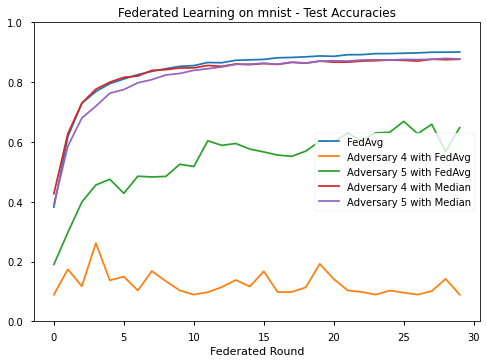

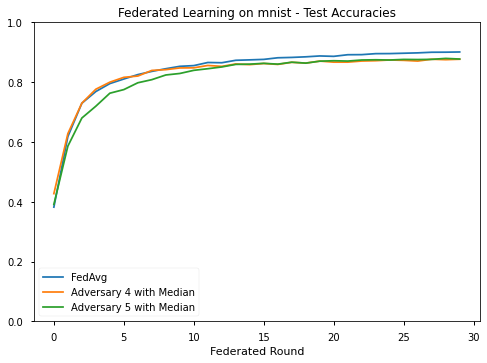

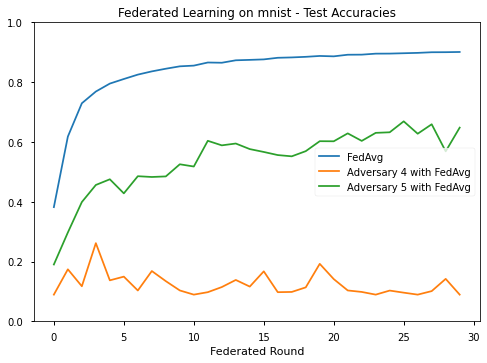

In [ ]:
plotServerAccuracy([testAccs,testAccsAdvMean, testAccsAdv5Mean, testAccsAdv4Median, testAccsAdv5Median], ['FedAvg', 'Adversary 4 with FedAvg', 'Adversary 5 with FedAvg', 'Adversary 4 with Median', 'Adversary 5 with Median'], '1.jpg')
plotServerAccuracy([testAccs, testAccsAdv4Median, testAccsAdv5Median], ['FedAvg',  'Adversary 4 with Median', 'Adversary 5 with Median'], '2.jpg')
plotServerAccuracy([testAccs,testAccsAdvMean, testAccsAdv5Mean], ['FedAvg', 'Adversary 4 with FedAvg', 'Adversary 5 with FedAvg'], '3.jpg')


In [ ]:
def plotClientAccuracy(clientAccs, isAdv, clientDesc, filename):
  plt.style.use('seaborn-notebook')

  legendCap = []

  for i in range(len(clientAccs)):
    if not isAdv[i]:
      legendCap.append(clientDesc[i])
      sns.lineplot(list(range(len(clientAccs[i]))), [v[0][0][1] for v in clientAccs[i]])
    else:
      legendCap.append(clientDesc[i] + ' (Adversary)')
      sns.lineplot(list(range(len(clientAccs[i]))), [v[0][0][1] for v in clientAccs[i]])
      legendCap.append(clientDesc[i] + ' (Honest)')
      sns.lineplot(list(range(len(clientAccs[i]))), [np.mean([v[i][0][1] for i in range(1,NUM_CLIENTS)]) for v in clientAccs[i]])

  plt.legend(legendCap, loc=0)
  plt.title('Federated Learning on mnist - Client Test Accuracies')
  plt.xlabel('Federated Round')
  plt.ylim(0, 1)
  plt.savefig(filename)
  plt.show()




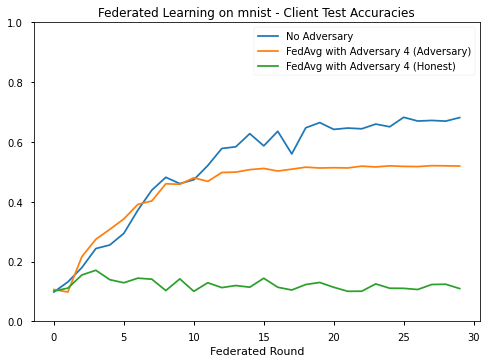

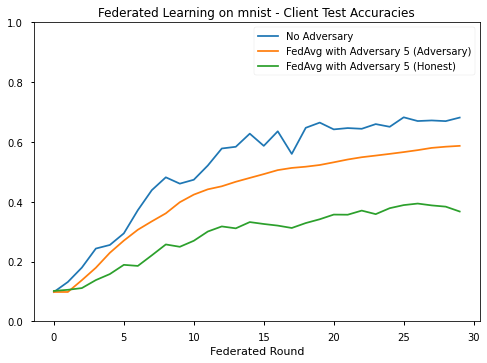

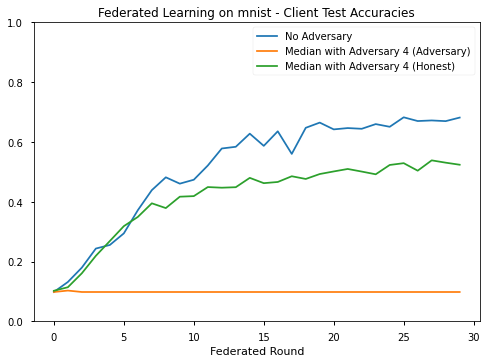

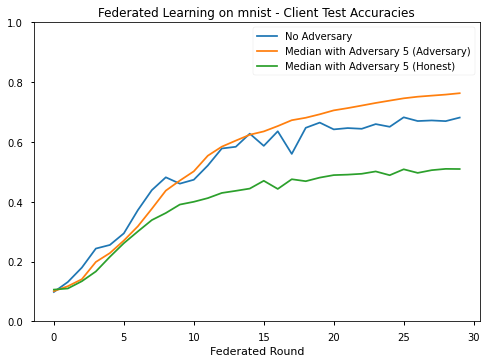

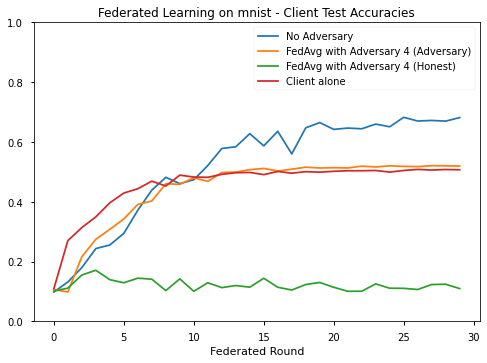

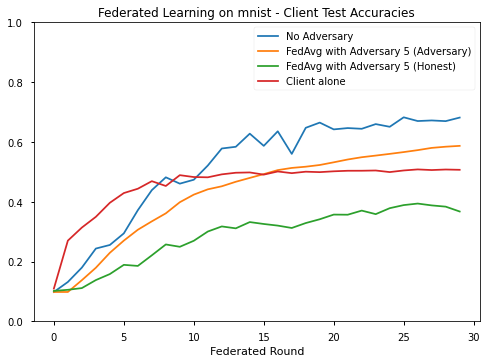

In [ ]:
plotClientAccuracy([clientResults,clientResultsAdvMean], [False, True], ['No Adversary', 'FedAvg with Adversary 4'], '4.jpg')
plotClientAccuracy([clientResults,clientResultsAdv5Mean], [False, True], ['No Adversary', 'FedAvg with Adversary 5'], '5.jpg')
plotClientAccuracy([clientResults,clientResultsAdv4Median], [False, True], ['No Adversary', 'Median with Adversary 4'], '6.jpg')
plotClientAccuracy([clientResults,clientResultsAdv5Median], [False, True], ['No Adversary', 'Median with Adversary 5'], '7.jpg')

plotClientAccuracy([clientResults,clientResultsAdvMean, referenceAccs], [False, True, False], ['No Adversary', 'FedAvg with Adversary 4', 'Client alone'], '8.jpg')
plotClientAccuracy([clientResults,clientResultsAdv5Mean, referenceAccs], [False, True, False], ['No Adversary', 'FedAvg with Adversary 5', 'Client alone'], '9.jpg')

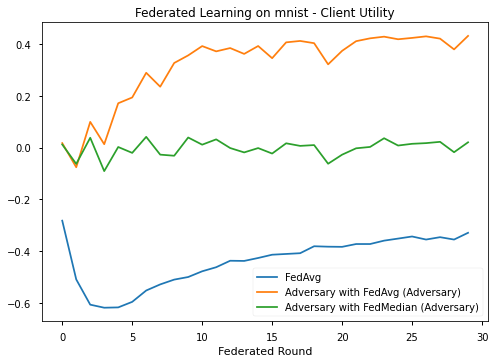

In [ ]:
plt.style.use('seaborn-notebook')
sns.lineplot(list(range(len(testAccs))), [np.mean([v[i][1] for i in range(0,NUM_CLIENTS)]) for v in clientResults])
sns.lineplot(list(range(len(testAccsAdvMean))), [v[0][1] for v in clientResultsAdvMean])
#sns.lineplot(list(range(len(testAccsAdvMedian))), [v[0][1] for v in clientResultsAdvMedian])
sns.lineplot(list(range(len(testAccsAdvMean))), [np.mean([v[i][1] for i in range(1,NUM_CLIENTS)]) for v in clientResultsAdvMean])
#sns.lineplot(list(range(len(testAccsAdvMedian))), [v[1][1] for v in clientResultsAdvMedian])
#plt.legend(['FedAvg', 'Adversary with FedAvg (Adversary)', 'Adversary with FedMedian (Adversary)', 'Adversary with FedAvg (Good)', 'Adversary with FedMedian (Good)'], loc=0)
plt.legend(['FedAvg', 'Adversary with FedAvg (Adversary)', 'Adversary with FedMedian (Adversary)'], loc=0)
plt.title('Federated Learning on mnist - Client Utility')
plt.xlabel('Federated Round')
# plt.ylim(0, 1)
#plt.savefig('figs/allacc.jpg')
plt.show()